## House Price Detection 

Import necessary libraries..

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, RobustScaler,
    OneHotEncoder, OrdinalEncoder, LabelEncoder)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
%load_ext autoreload 
%autoreload 2

In [4]:
import DataPreparation as prp
import re

<div style = "font-size:22px">
    
1. Import the data and analyze its rows, columns and data types
</div>

In [155]:
house_price_data = pd.read_csv('house_prices.csv').set_index('Index')
df = house_price_data.copy()

In [156]:
df.head(2)

,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,Furnishing,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
Index,,,,,,,,,,,,,,,,,,,,
0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,Unfurnished,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187531 entries, 0 to 187530
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Title              187531 non-null  object 
 1   Description        184508 non-null  object 
 2   Amount(in rupees)  187531 non-null  object 
 3   Price (in rupees)  169866 non-null  float64
 4   location           187531 non-null  object 
 5   Carpet Area        106858 non-null  object 
 6   Status             186916 non-null  object 
 7   Floor              180454 non-null  object 
 8   Transaction        187448 non-null  object 
 9   Furnishing         184634 non-null  object 
 10  facing             117298 non-null  object 
 11  overlooking        106095 non-null  object 
 12  Society            77853 non-null   object 
 13  Bathroom           186703 non-null  object 
 14  Balcony            138596 non-null  object 
 15  Car Parking        84174 non-null   object 
 16  Ownersh

<font size=4>
According to the observations, these data need lots of cleaning. Let's start data cleaning section.

## Cleaning the data

### Clean column names

Use our `prp.clean_columns()` function to clean the column names.  

In [158]:
df = prp.clean_columns(df,True)

In [159]:
df.columns

Index(['title', 'description', 'amount_in_rupees_', 'price__in_rupees_',
       'location', 'carpet_area', 'status', 'floor', 'transaction',
       'furnishing', 'facing', 'overlooking', 'society', 'bathroom', 'balcony',
       'car_parking', 'ownership', 'super_area', 'dimensions', 'plot_area'],
      dtype='object')

Column names are cleaned. But, some require further cleaning. Let's do this.

In [160]:
df = df.rename(columns = {'amount_in_rupees_': 'amount_in_rupees', 'price__in_rupees_':'price_in_rupees'})

In [161]:
df.columns

Index(['title', 'description', 'amount_in_rupees', 'price_in_rupees',
       'location', 'carpet_area', 'status', 'floor', 'transaction',
       'furnishing', 'facing', 'overlooking', 'society', 'bathroom', 'balcony',
       'car_parking', 'ownership', 'super_area', 'dimensions', 'plot_area'],
      dtype='object')

### Drop unnecessary columns:
- title
- description

In [162]:
df = df.drop(['title','description'], axis=1)

### amount_in_rupees column

<div style = 'font-size:24px'>
    
Now we should do exploratory data analysis on each column. As we can see, the `amount_in_rupees` column has numeric and string part. The string part has the meaning which shows the money unit. We should apply the following conversion to this column:


   
1. Take string part from the value
2. Apply appropriate unit conversion (from ruppes to dollar)
3. Create column `amount_in_dollars` and it will be float type
4. Drop the `amount_in_rupees` column.

In [163]:
units = [re.findall(r'[a-zA-Z\s]+',val) for val in df['amount_in_rupees']]
values = [re.findall(r'\d+\.?\d*',val) for val in df['amount_in_rupees']]

In [164]:
units_df = pd.DataFrame(units,columns=['unit'])
units_df['unit'].unique()

array([' Lac ', ' Cr ', 'Call for Price'], dtype=object)

In [165]:
usd_values = np.zeros(len(units))
exchange_rate = 0.012048

for i in range(len(units)):
    if len(values[i])==0:
        usd_values[i] = np.nan
    else: 
        amount = float(values[i][0])
        unit = units[i][0].strip().lower()
        if unit == 'lac':
            usd_values[i] = amount * exchange_rate * 100_000
        elif unit == 'cr':
            usd_values[i] = amount * exchange_rate * 10_000_000
        elif unit=='': 
            usd_values[i] = amount * exchange_rate
        else:
            usd_values[i] = np.nan
    

In [166]:
df['amount_in_usd'] = usd_values

In [167]:
df = df.drop('amount_in_rupees', axis=1)

In [168]:
df.head(2)

,price_in_rupees,location,carpet_area,status,floor,transaction,furnishing,facing,overlooking,society,bathroom,balcony,car_parking,ownership,super_area,dimensions,plot_area,amount_in_usd
Index,,,,,,,,,,,,,,,,,,
0,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,Unfurnished,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN,50601.6
1,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN,118070.4


### price_in_rupees column

<div style='font-size:24px'>

Let's analyze `price_in_rupees` column now:
1. this is float dtype column, no need to check uniqe values
2. convert float values into usd dollar
    
</div>

In [169]:
exchange_rate = 0.012048
df['price_in_usd'] = df['price_in_rupees']*exchange_rate

In [170]:
df = df.drop('price_in_rupees', axis=1)
df.head(2)

,location,carpet_area,status,floor,transaction,furnishing,facing,overlooking,society,bathroom,balcony,car_parking,ownership,super_area,dimensions,plot_area,amount_in_usd,price_in_usd
Index,,,,,,,,,,,,,,,,,,
0,thane,500 sqft,Ready to Move,10 out of 11,Resale,Unfurnished,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN,50601.6,72.288000
1,thane,473 sqft,Ready to Move,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN,118070.4,166.250352


### 'location' column

In [171]:
df['location'].unique()

array(['thane', 'navi-mumbai', 'nagpur', 'mumbai', 'ahmedabad',
       'bangalore', 'chennai', 'gurgaon', 'hyderabad', 'indore', 'jaipur',
       'kolkata', 'lucknow', 'new-delhi', 'noida', 'pune', 'agra',
       'ahmadnagar', 'allahabad', 'aurangabad', 'badlapur', 'belgaum',
       'bhiwadi', 'bhiwandi', 'bhopal', 'bhubaneswar', 'chandigarh',
       'coimbatore', 'dehradun', 'durgapur', 'ernakulam', 'faridabad',
       'ghaziabad', 'goa', 'greater-noida', 'guntur', 'guwahati',
       'gwalior', 'haridwar', 'jabalpur', 'jamshedpur', 'jodhpur',
       'kalyan', 'kanpur', 'kochi', 'kozhikode', 'ludhiana', 'madurai',
       'mangalore', 'mohali', 'mysore', 'nashik', 'navsari', 'nellore',
       'palakkad', 'palghar', 'panchkula', 'patna', 'pondicherry',
       'raipur', 'rajahmundry', 'ranchi', 'satara', 'shimla', 'siliguri',
       'solapur', 'sonipat', 'surat', 'thrissur', 'tirupati', 'trichy',
       'trivandrum', 'udaipur', 'udupi', 'vadodara', 'vapi', 'varanasi',
       'vijayawada',

There are too much unique values, we can not group them. Therefore, we can not use this column in our regression models. Therefore, we can drop this column.

In [172]:
df = df.drop('location',axis=1)

In [173]:
df.columns

Index(['carpet_area', 'status', 'floor', 'transaction', 'furnishing', 'facing',
       'overlooking', 'society', 'bathroom', 'balcony', 'car_parking',
       'ownership', 'super_area', 'dimensions', 'plot_area', 'amount_in_usd',
       'price_in_usd'],
      dtype='object')

### 'carpet_area' column

In [174]:
df['carpet_area'].unique()

array(['500 sqft', '473 sqft', '779 sqft', ..., '1634 sqft', '164 sqyrd',
       '136 sqft'], dtype=object)

In [175]:
units = [re.findall(r'[a-zA-Z\s]+', str(val))[0].strip() if re.findall(r'[a-zA-Z\s]+', str(val)) else '' 
         for val in df['carpet_area']]

values = [re.findall(r'\d+\.?\d*', str(val))[0] if re.findall(r'\d+\.?\d*', str(val)) else ''
         for val in df['carpet_area']]

In [176]:
carpet_area_df = pd.DataFrame(units, columns=['units'])
carpet_area_df['values'] = values
carpet_area_df

,units,values
0,sqft,500
1,sqft,473
2,sqft,779
3,sqft,530
4,sqft,635
...,...,...
187526,nan,
187527,nan,
187528,sqft,1250
187529,nan,


In [177]:
carpet_area_df['values'] = carpet_area_df['values'].replace('', np.nan)

In [178]:
carpet_area_df

,units,values
0,sqft,500
1,sqft,473
2,sqft,779
3,sqft,530
4,sqft,635
...,...,...
187526,nan,NaN
187527,nan,NaN
187528,sqft,1250
187529,nan,NaN


In [179]:
carpet_area_df['units'].unique()

array(['sqft', 'nan', 'sqm', 'sqyrd', 'acre', 'ground', 'cent', 'bigha',
       'marla', 'kanal'], dtype=object)

In [180]:
# now apply conversion to sqft
carpet_area_sqft = np.zeros(len(units))

for i in range(len(units)):
    unit = units[i]
    value = values[i]
    if value == '':
        value=np.nan
    else:
        value = float(value)

    if unit=='nan':
        carpet_area_sqft[i] = np.nan
    elif unit == 'sqft':
        carpet_area_sqft[i] = value
    elif unit == 'sqm':
        carpet_area_sqft[i] = value * 10.76
    elif unit == 'sqyrd':
        carpet_area_sqft[i] = value * 9
    elif unit == 'acre':
        carpet_area_sqft[i] = value * 43_560
    elif unit == 'ground':
        carpet_area_sqft[i] = value * 2_400
    elif unit == 'cent':
        carpet_area_sqft[i] = value * 435.6
    elif unit == 'bigha':
        carpet_area_sqft[i] = value * 9000
    elif unit == 'marla':
        carpet_area_sqft[i] = value * 272.25
    elif unit == 'kanal':
        carpet_area_sqft[i] = value * 5_445
    else: 
        carpet_area_sqft[i] = np.nan

In [181]:
df['carpet_area_sqft'] = carpet_area_sqft

In [182]:
df = df.drop('carpet_area',axis=1)

In [183]:
df.head(2)

,status,floor,transaction,furnishing,facing,overlooking,society,bathroom,balcony,car_parking,ownership,super_area,dimensions,plot_area,amount_in_usd,price_in_usd,carpet_area_sqft
Index,,,,,,,,,,,,,,,,,
0,Ready to Move,10 out of 11,Resale,Unfurnished,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN,50601.6,72.288000,500.0
1,Ready to Move,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN,118070.4,166.250352,473.0


### 'status' column

In [184]:
df['status'].unique()

array(['Ready to Move', nan], dtype=object)

In [185]:
df = df.drop('status',axis=1)

### 'floor' column

In [186]:
df['floor'].nunique()

947

We will apply feature engineering to this column:
1. extract the first number which will indicate the `current_floor` of the house.
2. extract the second number which will indicate the `total_floors` in the building.

In [187]:
df['floor'].unique()

array(['10 out of 11', '3 out of 22', '10 out of 29', '1 out of 3',
       '20 out of 42', '2 out of 7', '4 out of 5', 'Ground out of 7',
       'Ground out of 2', '3 out of 27', '6 out of 20', '16 out of 24',
       '8 out of 20', '18 out of 27', '2 out of 3', '10 out of 16',
       '5 out of 7', '20 out of 28', '3 out of 3', '3 out of 7',
       '15 out of 31', '2 out of 28', '27 out of 27', '6 out of 7',
       '5 out of 5', '3 out of 8', '11 out of 17', '9 out of 24',
       '16 out of 27', '14 out of 29', '12 out of 27', '1 out of 27',
       '2 out of 4', '16 out of 38', '3 out of 4', '2 out of 17',
       '12 out of 28', '3 out of 19', '6 out of 28', '1 out of 4',
       '7 out of 16', '2 out of 2', '1 out of 9', '7 out of 12',
       '10 out of 10', '4 out of 4', '14 out of 17', '21 out of 27',
       '5 out of 8', '7 out of 30', '6 out of 18', '14 out of 28',
       '3 out of 5', '2 out of 24', '1 out of 8', '2 out of 16',
       '7 out of 7', '4 out of 28', '4 out of 26', '1 

In [188]:
df['floor'] = df['floor'].str.replace(r'(?i)Lower basement','-2',regex=True).str.replace(r'(?i)Upper basement',
    '-1',regex=True).str.replace(r'(?i)Ground', '0', regex=True)

In [189]:
floors_in_column = [re.findall(r'-?\d+', str(val)) if re.findall(r'-?\d+', str(val)) else '' for val in df['floor'] ]
floors_in_column

[['10', '11'],
 ['3', '22'],
 ['10', '29'],
 ['1', '3'],
 ['20', '42'],
 ['2', '7'],
 ['4', '5'],
 ['0', '7'],
 ['0', '2'],
 ['3', '27'],
 ['6', '20'],
 ['16', '24'],
 ['8', '20'],
 ['18', '27'],
 ['2', '3'],
 ['10', '16'],
 ['5', '7'],
 ['4', '5'],
 ['20', '28'],
 ['3', '3'],
 ['3', '7'],
 ['15', '31'],
 ['2', '28'],
 ['27', '27'],
 ['6', '7'],
 ['5', '5'],
 ['3', '8'],
 ['11', '17'],
 ['8', '20'],
 ['9', '24'],
 ['16', '27'],
 ['14', '29'],
 ['12', '27'],
 ['1', '27'],
 ['2', '7'],
 ['5', '7'],
 ['2', '4'],
 ['2', '4'],
 ['16', '38'],
 ['2', '7'],
 ['3', '4'],
 ['2', '17'],
 ['12', '28'],
 ['3', '19'],
 ['2', '7'],
 ['5', '7'],
 ['6', '28'],
 ['1', '4'],
 ['5', '7'],
 ['7', '16'],
 ['2', '7'],
 ['2', '2'],
 ['1', '9'],
 ['7', '12'],
 ['10', '10'],
 ['4', '4'],
 ['6', '7'],
 ['14', '17'],
 ['21', '27'],
 ['5', '8'],
 ['7', '30'],
 ['6', '18'],
 ['14', '28'],
 ['3', '5'],
 ['2', '24'],
 ['3', '4'],
 ['1', '8'],
 ['2', '16'],
 ['7', '7'],
 ['4', '28'],
 ['4', '26'],
 ['5', '7'],
 ['7', 

In [190]:
current_floor = [int(val[0]) if isinstance(val, list) and len(val) >= 1 else np.nan 
                 for val in floors_in_column]

total_floors   = [int(val[1]) if isinstance(val, list) and len(val) >= 2 else np.nan 
                 for val in floors_in_column]


In [191]:
df['current_floor'] = current_floor
df['total_floors'] = total_floors

In [192]:
df.head(2)

,floor,transaction,furnishing,facing,overlooking,society,bathroom,balcony,car_parking,ownership,super_area,dimensions,plot_area,amount_in_usd,price_in_usd,carpet_area_sqft,current_floor,total_floors
Index,,,,,,,,,,,,,,,,,,
0,10 out of 11,Resale,Unfurnished,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN,50601.6,72.288000,500.0,10.0,11.0
1,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN,118070.4,166.250352,473.0,3.0,22.0


In [193]:
df = df.drop('floor', axis=1)
df.head(2)

,transaction,furnishing,facing,overlooking,society,bathroom,balcony,car_parking,ownership,super_area,dimensions,plot_area,amount_in_usd,price_in_usd,carpet_area_sqft,current_floor,total_floors
Index,,,,,,,,,,,,,,,,,
0,Resale,Unfurnished,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN,50601.6,72.288000,500.0,10.0,11.0
1,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN,118070.4,166.250352,473.0,3.0,22.0


### 'transaction' column

In [194]:
df['transaction'].unique()

array(['Resale', 'New Property', nan, 'Other', 'Rent/Lease'], dtype=object)

### 'furnishing' column

In [195]:
df['furnishing'].unique()

array(['Unfurnished', 'Semi-Furnished', 'Furnished', nan], dtype=object)

### 'facing' column

In [196]:
df['facing'].unique()

array([nan, 'East', 'West', 'North - East', 'North', 'North - West',
       'South', 'South -West', 'South - East'], dtype=object)

### 'overlooking' column

In [197]:
df['overlooking'].unique()

array([nan, 'Garden/Park', 'Garden/Park, Main Road', 'Main Road',
       'Pool, Garden/Park, Main Road', 'Garden/Park, Pool, Main Road',
       'Garden/Park, Pool', 'Main Road, Garden/Park',
       'Main Road, Garden/Park, Pool', 'Pool, Garden/Park', 'Pool',
       'Garden/Park, Main Road, Pool', 'Pool, Main Road',
       'Main Road, Pool, Garden/Park', 'Pool, Main Road, Garden/Park',
       'Main Road, Not Available', 'Main Road, Pool',
       'Garden/Park, Pool, Main Road, Not Available',
       'Garden/Park, Not Available', 'Pool, Main Road, Not Available'],
      dtype=object)

We can group the values inside this column as:
- Park
- Park_MainRoad
- MainRoad
- Pool_Park_MainRoad
- Pool_Park
- Pool
- Pool_MainRoad
  

In [198]:
overlooking_map = {'nan':'', 'Garden/Park':'Park', 'Garden/Park, Main Road':'Park_MainRoad',
                  'Main Road':'MainRoad','Pool, Garden/Park, Main Road':'Pool_Park_MainRoad',
                   'Garden/Park, Pool, Main Road':'Pool_Park_MainRoad',
       'Garden/Park, Pool' : 'Pool_Park', 'Main Road, Garden/Park' : 'Park_MainRoad',
       'Main Road, Garden/Park, Pool' : 'Pool_Park_MainRoad', 'Pool, Garden/Park' : 'Pool_Park', 'Pool' : 'Pool',
       'Garden/Park, Main Road, Pool' : 'Pool_Park_MainRoad', 'Pool, Main Road' : 'Pool_MainRoad',
       'Main Road, Pool, Garden/Park' : 'Pool_Park_MainRoad', 'Pool, Main Road, Garden/Park' : 'Pool_Park_MainRoad',
       'Main Road, Not Available' : 'MainRoad', 'Main Road, Pool' : 'Pool_MainRoad',
       'Garden/Park, Pool, Main Road, Not Available' : 'Pool_Park_MainRoad',
       'Garden/Park, Not Available' : 'Park', 'Pool, Main Road, Not Available' : 'Pool_MainRoad'}

In [199]:
df['overlooking'] = df['overlooking'].astype(str).str.strip()

In [200]:
df['overlooking_groupped'] = df['overlooking'].apply(lambda x: overlooking_map.get(x,x))

In [201]:
df = df.drop('overlooking',axis=1)

In [202]:
df.head(2)

,transaction,furnishing,facing,society,bathroom,balcony,car_parking,ownership,super_area,dimensions,plot_area,amount_in_usd,price_in_usd,carpet_area_sqft,current_floor,total_floors,overlooking_groupped
Index,,,,,,,,,,,,,,,,,
0,Resale,Unfurnished,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN,50601.6,72.288000,500.0,10.0,11.0,
1,Resale,Semi-Furnished,East,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN,118070.4,166.250352,473.0,3.0,22.0,Park


### 'society' column

In [203]:
len(df['society'].unique())

10377

In [204]:
# too many unique values

In [205]:
df = df.drop('society', axis=1)

### 'bathroom' column 

In [206]:
df['bathroom'].unique()

array(['1', '2', '3', '4', '6', nan, '5', '10', '9', '8', '> 10', '7'],
      dtype=object)

### 'balcony' column

In [207]:
df['balcony'].unique()

array(['2', nan, '1', '3', '4', '> 10', '6', '5', '7', '10', '8', '9'],
      dtype=object)

In [208]:
df['balcony'] = df['balcony'].str.replace(r'\s+','', regex=True)

In [209]:
df['balcony'].unique()

array(['2', nan, '1', '3', '4', '>10', '6', '5', '7', '10', '8', '9'],
      dtype=object)

### 'car_parking' column

In [210]:
prp.check_missing(data=df, columns='car_parking')

,Missing,%_of_total
car_parking,103357,55.11


In [211]:
# drop the column
df = df.drop('car_parking',axis=1)

### 'ownership' column

In [212]:
prp.check_missing(data=df, columns='ownership')

,Missing,%_of_total
ownership,65517,34.94


In [213]:
df['ownership'].unique()

array([nan, 'Freehold', 'Co-operative Society', 'Power Of Attorney',
       'Leasehold'], dtype=object)

### 'super_area' column

In [214]:
prp.check_missing(data=df, columns='super_area')

,Missing,%_of_total
super_area,107685,57.42


In [215]:
# more than half of the column is empty. Therefore, just drop it
df = df.drop('super_area',axis=1)

### 'dimensions' column

In [216]:
prp.check_missing(data=df, columns='dimensions')

,Missing,%_of_total
dimensions,187531,100.0


In [217]:
# drop the column
df = df.drop('dimensions',axis=1)

### 'plot_area' column

In [218]:
prp.check_missing(data=df, columns='plot_area')

,Missing,%_of_total
plot_area,187531,100.0


In [219]:
df = df.drop('plot_area', axis=1)

## Check missing values

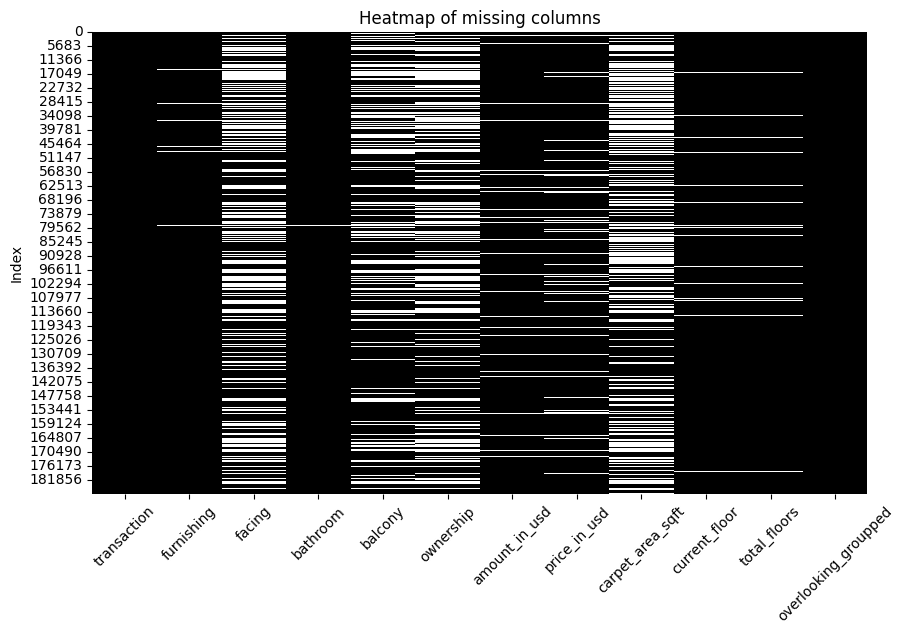

,Missing,%_of_total
transaction,83,0.04
furnishing,2897,1.54
facing,70233,37.45
bathroom,828,0.44
balcony,48935,26.09
ownership,65517,34.94
amount_in_usd,9684,5.16
price_in_usd,17665,9.42
carpet_area_sqft,80673,43.02
current_floor,7077,3.77


In [220]:
prp.check_missing(data=df, visual=True)

In [221]:
numeric_cols = df.select_dtypes(include='object').columns

In [222]:
numeric_cols

Index(['transaction', 'furnishing', 'facing', 'bathroom', 'balcony',
       'ownership', 'overlooking_groupped'],
      dtype='object')

In [223]:
cols_fill_with_mean = ['amount_in_usd', 'price_in_usd', 'current_floor', 'total_floors']

In [224]:
df = prp.handle_missing(data=df, columns = cols_fill_with_mean, dtype='number', by = 'mean')

In [225]:
prp.check_missing(data=df)

,Missing,%_of_total
transaction,83,0.04
furnishing,2897,1.54
facing,70233,37.45
bathroom,828,0.44
balcony,48935,26.09
ownership,65517,34.94
amount_in_usd,0,0.00
price_in_usd,0,0.00
carpet_area_sqft,80673,43.02
current_floor,0,0.00


In [226]:
cols_fill_with_mode = ['transaction','furnishing','facing','bathroom','balcony']

In [227]:
df = prp.handle_missing(df,cols_fill_with_mode,dtype='object',by='mode')

In [228]:
df['ownership'] = df['ownership'].fillna('Unknown')

In [229]:
#  find correlation between carpet_area and price in dollars, amount in usd

In [230]:
cols = ['price_in_usd','amount_in_usd']
target = 'carpet_area_sqft'

In [231]:
prp.correlation(data=df, columns=cols, target=target, width=10, height=4)

,carpet_area_sqft,amount_in_usd,price_in_usd
carpet_area_sqft,1.0,0.000183,-0.000311


In [232]:
df = df.drop('carpet_area_sqft', axis=1)

## Check outliers for numeric columns

In [233]:
numeric_cols = df.select_dtypes(include='number').columns

In [234]:
prp.check_outliers(data=df, columns=numeric_cols)

,num_of_outliers,perc_of_total
amount_in_usd,174,0.09
price_in_usd,18,0.01
current_floor,2969,1.58
total_floors,3967,2.12


In [235]:
df = prp.handle_outliers(data=df, columns=numeric_cols, by='coerce')

In [236]:
prp.check_outliers(data=df, columns=numeric_cols)

,num_of_outliers,perc_of_total
amount_in_usd,0,0.0
price_in_usd,0,0.0
current_floor,0,0.0
total_floors,0,0.0


## Clean values for categoric columns

In [237]:
categoric_cols = df.select_dtypes(include='object').columns

In [238]:
categoric_cols

Index(['transaction', 'furnishing', 'facing', 'bathroom', 'balcony',
       'ownership', 'overlooking_groupped'],
      dtype='object')

In [239]:
df = prp.clean_values(data=df, column='transaction', lowercase=True)

In [240]:
df = prp.clean_values(data=df, column='furnishing', lowercase=True)

In [241]:
df = prp.clean_values(data=df, column='facing', lowercase=True)

In [242]:
df = prp.clean_values(data=df, column='ownership', lowercase=True)

In [243]:
df = prp.clean_values(data=df, column='overlooking_groupped', lowercase=True)

In [244]:
df = df.rename(columns={'overlooking_groupped':'overlooking'})

In [245]:
# Remove leading/trailing whitespace
df['overlooking'] = df['overlooking'].astype(str).str.strip()

# Replace empty strings with 'Unknown'
df['overlooking'] = df['overlooking'].replace('', 'Unknown')

In [246]:
df.head(5)

,transaction,furnishing,facing,bathroom,balcony,ownership,amount_in_usd,price_in_usd,current_floor,total_floors,overlooking
Index,,,,,,,,,,,
0,resale,unfurnished,east,1,2,unknown,50601.6,72.288000,9.5,11.0,Unknown
1,resale,semi-furnished,east,2,2,freehold,118070.4,166.250352,3.0,21.5,park
2,resale,unfurnished,east,2,2,freehold,168672.0,173.238192,9.5,21.5,park
3,resale,unfurnished,east,1,1,unknown,30120.0,91.369284,1.0,3.0,Unknown
4,resale,unfurnished,west,2,2,co-operative_society,192768.0,173.238192,9.5,21.5,park_mainroad


In [247]:
df['furnishing'].value_counts()

furnishing
semi-furnished    91215
unfurnished       76154
furnished         20162
Name: count, dtype: int64

## Feature selection on categorical columns

In [248]:
target = 'transaction'

In [249]:
column = ['price_in_usd']

In [250]:
res = prp.anova(data=df, columns = column, target = target )

In [251]:
res

,f_stat,p_value,significance
price_in_usd,249.521239,0.0,sign.


Transaction column is important. Therefore, don't drop it

In [252]:
target = 'furnishing'
column = ['price_in_usd']

In [253]:
prp.anova(data=df, columns = column, target = target )

,f_stat,p_value,significance
price_in_usd,171.799913,0.0,sign.


In [254]:
target = 'facing'
column = ['price_in_usd']

In [255]:
prp.anova(data=df, columns = column, target = target )

,f_stat,p_value,significance
price_in_usd,981.338751,0.0,sign.


In [256]:
target = 'ownership'
column = ['price_in_usd']

In [257]:
prp.anova(data=df, columns = column, target = target )

,f_stat,p_value,significance
price_in_usd,1480.182438,0.0,sign.


In [258]:
target = 'overlooking'
column = ['price_in_usd']

In [259]:
prp.anova(data=df, columns = column, target = target )

,f_stat,p_value,significance
price_in_usd,1952.332996,0.0,sign.


We don't drop the columns

## Scale numerical variables

In [260]:
numeric_cols = df.select_dtypes(include='number').columns

In [261]:
df = prp.scale_variables(data=df, method='standard', columns = numeric_cols, overwrite = True)

In [262]:
df.head(2)

,transaction,furnishing,facing,bathroom,balcony,ownership,amount_in_usd,price_in_usd,current_floor,total_floors,overlooking
Index,,,,,,,,,,,
0,resale,unfurnished,east,1,2,unknown,-0.856532,-0.328526,1.921103,0.470203,Unknown
1,resale,semi-furnished,east,2,2,freehold,-0.089321,2.072456,-0.293980,2.267462,park


## Encode categorical variables

In [263]:
categoric_cols = ['transaction', 'furnishing','facing','ownership','overlooking']

In [264]:
df = prp.encode_variables(data=df, columns=categoric_cols, method='dummy')

In [265]:
df

,bathroom,balcony,amount_in_usd,price_in_usd,current_floor,total_floors,transaction_other,transaction_rent/lease,transaction_resale,furnishing_semi-furnished,...,ownership_leasehold,ownership_power_of_attorney,ownership_unknown,overlooking_mainroad,overlooking_park,overlooking_park_mainroad,overlooking_pool,overlooking_pool_mainroad,overlooking_pool_park,overlooking_pool_park_mainroad
Index,,,,,,,,,,,,,,,,,,,,,
0,1,2,-0.856532,-0.328526,1.921103,0.470203,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,2,2,-0.089321,2.072456,-0.293980,2.267462,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2,2,2,0.486087,2.251014,1.921103,2.267462,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1,1,-1.089435,0.159050,-0.975544,-0.899138,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,2,2,0.760090,2.251014,1.921103,2.267462,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187526,3,3,-0.568828,-1.182831,-0.634762,-0.727970,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
187527,3,2,-0.678429,-1.167746,0.046802,-0.385635,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
187528,3,2,-0.390725,-0.838646,-0.975544,-0.899138,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [266]:
df['balcony'].unique()

array(['2', '1', '3', '4', '>10', '6', '5', '7', '10', '8', '9'],
      dtype=object)

In [267]:
df = prp.encode_variables(data=df, columns='bathroom', method='ordinalencoder',
                         order_dict={'bathroom': ['1', '2', '3', '4', '5', '6', '7', '8' ,'9','10', '> 10']})

In [268]:
df = prp.encode_variables(data=df, columns='balcony', method='ordinalencoder',
                         order_dict={'balcony': ['1', '2', '3', '4', '5', '6', '7', '8' ,'9','10', '>10']})

In [269]:
df

,bathroom,balcony,amount_in_usd,price_in_usd,current_floor,total_floors,transaction_other,transaction_rent/lease,transaction_resale,furnishing_semi-furnished,...,ownership_unknown,overlooking_mainroad,overlooking_park,overlooking_park_mainroad,overlooking_pool,overlooking_pool_mainroad,overlooking_pool_park,overlooking_pool_park_mainroad,bathroom_encoded,balcony_encoded
Index,,,,,,,,,,,,,,,,,,,,,
0,1,2,-0.856532,-0.328526,1.921103,0.470203,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,2,2,-0.089321,2.072456,-0.293980,2.267462,0,0,1,1,...,0,0,1,0,0,0,0,0,1,1
2,2,2,0.486087,2.251014,1.921103,2.267462,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1
3,1,1,-1.089435,0.159050,-0.975544,-0.899138,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,2,2,0.760090,2.251014,1.921103,2.267462,0,0,1,0,...,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187526,3,3,-0.568828,-1.182831,-0.634762,-0.727970,0,0,0,1,...,0,0,1,0,0,0,0,0,2,2
187527,3,2,-0.678429,-1.167746,0.046802,-0.385635,0,0,1,0,...,1,0,0,1,0,0,0,0,2,1
187528,3,2,-0.390725,-0.838646,-0.975544,-0.899138,0,0,1,0,...,0,0,0,1,0,0,0,0,2,1


In [270]:
df = df.drop(['bathroom','balcony'],axis=1)

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187531 entries, 0 to 187530
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   amount_in_usd                   187531 non-null  float64
 1   price_in_usd                    187531 non-null  float64
 2   current_floor                   187531 non-null  float64
 3   total_floors                    187531 non-null  float64
 4   transaction_other               187531 non-null  int64  
 5   transaction_rent/lease          187531 non-null  int64  
 6   transaction_resale              187531 non-null  int64  
 7   furnishing_semi-furnished       187531 non-null  int64  
 8   furnishing_unfurnished          187531 non-null  int64  
 9   facing_north                    187531 non-null  int64  
 10  facing_north_-_east             187531 non-null  int64  
 11  facing_north_-_west             187531 non-null  int64  
 12  facing_south         

## Regression model

In [272]:
X = df.drop('price_in_usd', axis=1)

In [273]:
y = df['price_in_usd']

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42,shuffle=True)

In [275]:
model = LinearRegression()

In [276]:
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [277]:
y_pred = model.predict(X_test)

In [278]:
r2_score(y_test, y_pred)

0.7244200114492649

In [279]:
mean_absolute_percentage_error(y_test, y_pred)

1.332485140291423

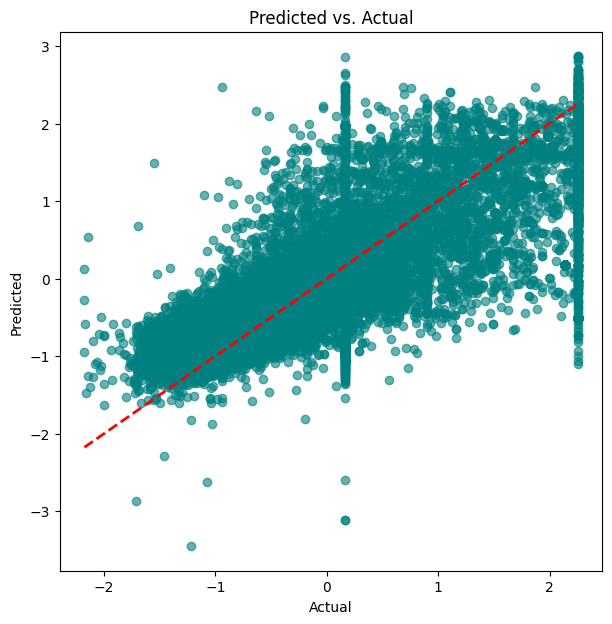

In [280]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6, color="teal")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs. Actual")
plt.show()

In [281]:
model.intercept_

np.float64(0.8853938786097098)

In [282]:
model.coef_

array([ 1.04410395, -0.05270063,  0.01210614,  0.60387569, -0.11588051,
       -0.03494054, -0.18338063, -0.0754529 , -0.00776999, -0.0503396 ,
        0.17779615, -0.06849262, -0.22077869, -0.01141094,  0.04862253,
       -0.14461104, -0.1252966 , -0.27196948, -0.16652493, -0.09079836,
       -0.10255321, -0.06632872,  0.20524085, -0.17004977,  0.11130331,
       -0.03771068, -0.40203799,  0.02812025])

## Remove some categorical variables

In [283]:
df.head(2)

,amount_in_usd,price_in_usd,current_floor,total_floors,transaction_other,transaction_rent/lease,transaction_resale,furnishing_semi-furnished,furnishing_unfurnished,facing_north,...,ownership_unknown,overlooking_mainroad,overlooking_park,overlooking_park_mainroad,overlooking_pool,overlooking_pool_mainroad,overlooking_pool_park,overlooking_pool_park_mainroad,bathroom_encoded,balcony_encoded
Index,,,,,,,,,,,,,,,,,,,,,
0,-0.856532,-0.328526,1.921103,0.470203,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,-0.089321,2.072456,-0.293980,2.267462,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,1


In [284]:
df.columns

Index(['amount_in_usd', 'price_in_usd', 'current_floor', 'total_floors',
       'transaction_other', 'transaction_rent/lease', 'transaction_resale',
       'furnishing_semi-furnished', 'furnishing_unfurnished', 'facing_north',
       'facing_north_-_east', 'facing_north_-_west', 'facing_south',
       'facing_south_-_east', 'facing_south_-west', 'facing_west',
       'ownership_freehold', 'ownership_leasehold',
       'ownership_power_of_attorney', 'ownership_unknown',
       'overlooking_mainroad', 'overlooking_park', 'overlooking_park_mainroad',
       'overlooking_pool', 'overlooking_pool_mainroad',
       'overlooking_pool_park', 'overlooking_pool_park_mainroad',
       'bathroom_encoded', 'balcony_encoded'],
      dtype='object')

In [285]:
df = df.drop(['ownership_freehold', 'ownership_leasehold',
       'ownership_power_of_attorney', 'ownership_unknown',
       'overlooking_mainroad', 'overlooking_park', 'overlooking_park_mainroad',
       'overlooking_pool', 'overlooking_pool_mainroad',
       'overlooking_pool_park', 'overlooking_pool_park_mainroad'], axis=1)

In [286]:
X = df.drop('price_in_usd', axis=1)
y = df['price_in_usd']

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42,shuffle=True)

In [288]:
model = LinearRegression()

In [289]:
model = model.fit(X_train, y_train)

In [290]:
y_pred = model.predict(X_test)

In [291]:
r2_score(y_test, y_pred)

0.7220685705682606

In [292]:
mean_absolute_percentage_error(y_test, y_pred)

1.3309057417416272

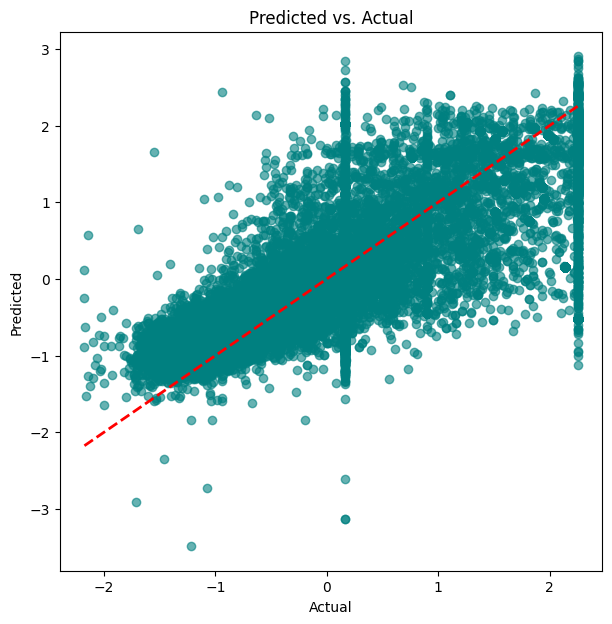

In [294]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6, color="teal")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs. Actual")
plt.show()

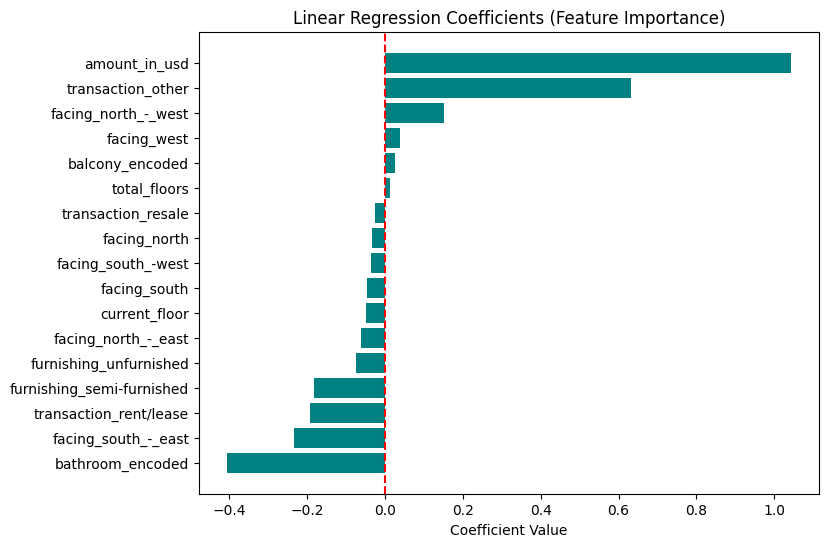

In [295]:
coefs = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_
}).sort_values(by='coefficient', ascending=True)  # sort for nicer plot

# plot as bar chart
plt.figure(figsize=(8,6))
plt.barh(coefs['feature'], coefs['coefficient'], color='teal')
plt.axvline(0, color='red', linestyle='--')  # line at 0 for reference
plt.xlabel("Coefficient Value")
plt.title("Linear Regression Coefficients (Feature Importance)")
plt.show()

In [296]:
df.columns

Index(['amount_in_usd', 'price_in_usd', 'current_floor', 'total_floors',
       'transaction_other', 'transaction_rent/lease', 'transaction_resale',
       'furnishing_semi-furnished', 'furnishing_unfurnished', 'facing_north',
       'facing_north_-_east', 'facing_north_-_west', 'facing_south',
       'facing_south_-_east', 'facing_south_-west', 'facing_west',
       'bathroom_encoded', 'balcony_encoded'],
      dtype='object')